## 4. Modeling
### 4.1 Loading libraries & dataset

In [1]:
library("FSinR")
library("data.table")
library("magrittr")
library("ggplot2")

In [2]:
train_module_scaled=fread("train_module_scaled.csv")

In [3]:
train_module_scaled$Id=as.factor(train_module_scaled$Id)
train_module_scaled$Channels=as.factor(train_module_scaled$Channels)
train_module_scaled$Segments=as.factor(train_module_scaled$Segments)
train_module_scaled$label=as.factor(train_module_scaled$label)

### 4.2 Feature selection : Univariate filter selection 

Select K best using  Chi_squared
https://dicits.ugr.es/software/FSinR/

Compute chi-squared stats between each non-negative feature and class.

This score can be used to select the n_features features with the highest values for the test chi-squared statistic from X, which must contain only non-negative features such as booleans or frequencies (e.g., term counts in document classification), relative to the classes.

Recall that the chi-square test measures dependence between stochastic variables, so using this function “weeds out” the features that are the most likely to be independent of class and therefore irrelevant for classification.

In [8]:
evaluator <- filterEvaluator('chiSquared')

directSearcher <- directSearchAlgorithm('selectKBest', list(k=10))

results <- directFeatureSelection(train_module_scaled, 'label', directSearcher, evaluator)
results$bestFeatures

results$featuresSelected

results$valuePerFeature

Id,Channels,Segments,V1,V2,V3,V4,V5,V6,V7,⋯,V491,V492,V493,V494,V495,V496,V497,V498,V499,V500
1,0,0,0,0,0,1,1,1,1,⋯,0,0,0,0,0,0,0,1,1,1


[1] "Id"   "V380" "V5"   "V499" "V6"   "V379" "V500" "V4"   "V498" "V7"

[1] 264880.0 217012.3 216521.3 216518.4 216445.8 216338.3 216332.5 216312.2
 [9] 216193.1 216166.9

We select only the best feature, we added the categorical variable (segment and channel), we removed id

In [4]:
train_select=train_module_scaled[,c(2,3,7,8,9,10,382,383,501,502,504)]

In [5]:
train_select_nofactor=train_module_scaled[,c(7,8,9,10,382,383,501,502,504)]

### 4.3 First model : logistic regression & class balancing technique

Using mlr3 package for modeling : https://mlr3.mlr-org.com/index.html
https://mlr3book.mlr-org.com/basics.html

In [5]:
library("mlr3") # mlr3 base package
library("mlr3misc") # contains some helper functions
library("mlr3pipelines") # create ML pipelines
library("mlr3tuning") # tuning ML algorithms
library("mlr3learners") # additional ML algorithms
library("mlr3viz") # autoplot for benchmarks
library("skimr")
library("GGally")


Attaching package: ‘mlr3misc’


The following objects are masked from ‘package:magrittr’:

    set_class, set_names


Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2



Create a Task from mlr3 that we will use for each model.

In [6]:
task = TaskClassif$new(id = "Task", backend = train_select,target = "label")
task

<TaskClassif:Task> (264880 x 11)
* Target: label
* Properties: twoclass
* Features (10):
  - dbl (8): V379, V380, V4, V498, V499, V5, V6, V7
  - fct (2): Channels, Segments

In [22]:
task_nofactor=TaskClassif$new(id = "Task", backend = train_select_nofactor,target = "label")

Let us plot a summary view of our data

In [17]:
skim(task$data())

── Data Summary ────────────────────────
                           Values     
Name                       task$data()
Number of rows             264880     
Number of columns          11         
_______________________               
Column type frequency:                
  factor                   3          
  numeric                  8          
________________________              
Group variables            None       

── Variable type: factor ───────────────────────────────────────────────────────
  skim_variable n_missing complete_rate ordered n_unique
1 label                 0             1 FALSE          2
2 Channels              0             1 FALSE          7
3 Segments              0             1 FALSE         40
  top_counts                            
1 0: 206360, 1: 58520                   
2 1: 37840, 2: 37840, 3: 37840, 4: 37840
3 1: 6622, 2: 6622, 3: 6622, 4: 6622    

── Variable type: numeric ──────────────────────────────────────────────────────
  skim_variab

Plot correlation analysis with selected feature expect factor

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



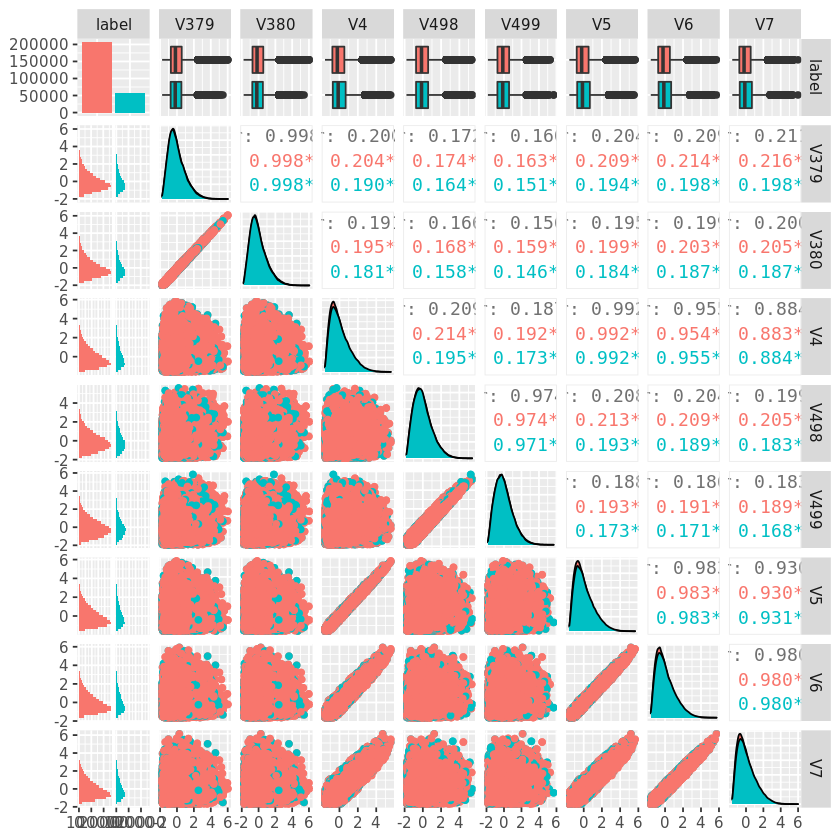

In [15]:
autoplot(task_nofactor, type = "pairs")

First, let us define a lositic regression

In [7]:
library("mlr3learners")
learner_logreg = lrn("classif.log_reg")
learner_logreg$predict_type <- "prob"
print(learner_logreg)

<LearnerClassifLogReg:classif.log_reg>
* Model: -
* Parameters: list()
* Packages: stats
* Predict Type: prob
* Feature types: logical, integer, numeric, character, factor, ordered
* Properties: twoclass, weights


In [8]:
# check original class balance
table(task$truth())


     0      1 
206360  58520 

Create class balancing technique : under, over and none

In [9]:
po_under = po("classbalancing",
  id = "undersample", adjust = "major",
  reference = "major", ratio = 58520  / 206360  )
# reduce majority class by factor '1/ratio'
table(po_under$train(list(task))$output$truth())


    0     1 
58520 58520 

Create a pipe combining undersampling with Log reg learner within mlr3 Graph Learner

In [10]:
graph_down = GraphLearner$new(po_under %>>% learner_logreg)
graph_down$predict_type <- "prob"

Apply same steps for oversampling

In [11]:
lrn_up = po("classbalancing", id = "oversample", adjust = "minor", 
     reference = "minor", shuffle = FALSE, ratio =206360 / 58520  ) %>>%
  learner_logreg

In [12]:
graph_up <- GraphLearner$new(lrn_up)
graph_up$predict_type <- "prob"

Here we want to benchmark (compare) the results of the different technique. To do that, we use benchmark_grid of mlr3.

Define a splitting technique for benchmark. Here we want that the bench performs on the same split,i.e rsmp("holdout")

In [13]:
hld <- rsmp("holdout")

set.seed(123)
hld$instantiate(task)

In [14]:
bmr <- benchmark(design = benchmark_grid(task = task,
                                        learner = list(learner_logreg,graph_up,
                                                       graph_down),
                                        hld),
                store_models = TRUE) #only needed if you want to inspect the models

INFO  [22:10:31.163] [mlr3]  Benchmark with 3 resampling iterations 
INFO  [22:10:31.313] [mlr3]  Applying learner 'undersample.classif.log_reg' on task 'Task' (iter 1/1) 
INFO  [22:10:32.064] [mlr3]  Applying learner 'oversample.classif.log_reg' on task 'Task' (iter 1/1) 
INFO  [22:10:34.505] [mlr3]  Applying learner 'classif.log_reg' on task 'Task' (iter 1/1) 
INFO  [22:10:36.689] [mlr3]  Finished benchmark 


Retrive results from benchmark with the accuracy metrics (used for the challenge)

In [15]:
bmr$aggregate(msr("classif.acc"))

nr,resample_result,task_id,learner_id,resampling_id,iters,classif.acc
<int>,<list>,<chr>,<chr>,<chr>,<int>,<dbl>
1,<environment: 0xf7fffc0>,Task,classif.log_reg,holdout,1,0.7802431
2,<environment: 0xed97758>,Task,oversample.classif.log_reg,holdout,1,0.5533281
3,<environment: 0x10cb7758>,Task,undersample.classif.log_reg,holdout,1,0.5493074


Same for recall and precision

In [16]:
bmr$aggregate(msr("classif.recall"))

nr,resample_result,task_id,learner_id,resampling_id,iters,classif.recall
<int>,<list>,<chr>,<chr>,<chr>,<int>,<dbl>
1,<environment: 0x8f932fa8>,Task,classif.log_reg,holdout,1,1.0000000
2,<environment: 0x8f94ac98>,Task,oversample.classif.log_reg,holdout,1,0.5719988
3,<environment: 0x8f95eb58>,Task,undersample.classif.log_reg,holdout,1,0.5667731


In [17]:
bmr$aggregate(msr("classif.precision"))

nr,resample_result,task_id,learner_id,resampling_id,iters,classif.precision
<int>,<list>,<chr>,<chr>,<chr>,<int>,<dbl>
1,<environment: 0x2cbbde48>,Task,classif.log_reg,holdout,1,0.7802431
2,<environment: 0x2cbd1d08>,Task,oversample.classif.log_reg,holdout,1,0.7983508
3,<environment: 0x2cbe99f8>,Task,undersample.classif.log_reg,holdout,1,0.7969506


=> Over and undersampling technique do not increase accuracy. Precision is slighlyt better with class balance sampling technique.  
But the recall value of classif.log_reg is too high (=1).   

We define a train/test split and train our different learners to have a detailed view on the prediction. 

In [18]:
# train/test split
train_set <- sample(task$nrow, 0.8 * task$nrow)
test_set <- setdiff(seq_len(task$nrow), train_set)

# train the model
learner_logreg$train(task, row_ids = train_set)

# predict data
prediction <- learner_logreg$predict(task, row_ids = test_set)

# calculate performance
prediction$confusion

        truth
response     0     1
       0 41195 11781
       1     0     0

In [19]:
measure <- list(msr("classif.acc"), msr("classif.precision"))
prediction$score(measure)

classif.acc classif.precision 
        0.7776163         0.7776163

=> From this first model, we can notice that the better accuracy is confirmed for no sampling techniques. 
Nontheless, we can notice from our confusion matrix that this model do not distinct man and woman. 
The model has predicted that all ids are men.   
One of the main reason is probably coming from imbalanced data. Let us confirm that.

In [20]:
# train/test split
train_set <- sample(task$nrow, 0.8 * task$nrow)
test_set <- setdiff(seq_len(task$nrow), train_set)

# train the model
graph_down$train(task, row_ids = train_set)

# predict data
prediction <- graph_down$predict(task, row_ids = test_set)

# calculate performance
prediction$confusion

        truth
response     0     1
       0 24107  6157
       1 17062  5650

In [21]:
measure <- list(msr("classif.acc"), msr("classif.precision"), msr("classif.recall") )
prediction$score(measure)

classif.acc classif.precision    classif.recall 
        0.5617072         0.7965570         0.5855620

Here, we can notice that thanks to undersampling the model can distinct men and women. Let us see the results for oversampling.

In [22]:
# train/test split
train_set <- sample(task$nrow, 0.8 * task$nrow)
test_set <- setdiff(seq_len(task$nrow), train_set)

# train the model
graph_up$train(task, row_ids = train_set)

# predict data
prediction <- graph_up$predict(task, row_ids = test_set)

# calculate performance
prediction$confusion

        truth
response     0     1
       0 24083  6167
       1 17118  5608

In [23]:
measure <- list(msr("classif.acc"), msr("classif.precision"), msr("classif.recall") )
prediction$score(measure)

classif.acc classif.precision    classif.recall 
        0.5604613         0.7961322         0.5845246

=> Precision better, accuracy lower. 

Let us use resampling technique with Cross validation set to 3 in order to check consistancy of oversampling technique. 

In [25]:
# automatic resampling
resampling <- rsmp("cv", folds = 3L)
rr <- resample(task, graph_up, resampling)
rr$score(measure)

INFO  [17:04:50.536] Applying learner 'oversample.classif.log_reg' on task 'Task' (iter 2/3) 
INFO  [17:04:53.243] Applying learner 'oversample.classif.log_reg' on task 'Task' (iter 1/3) 
INFO  [17:04:55.702] Applying learner 'oversample.classif.log_reg' on task 'Task' (iter 3/3) 


task,task_id,learner,learner_id,resampling,resampling_id,iteration,prediction,classif.acc,classif.precision,classif.recall
<list>,<chr>,<list>,<chr>,<list>,<chr>,<int>,<list>,<dbl>,<dbl>,<dbl>
<environment: 0xe8a6008>,Task,<environment: 0x112bbeb8>,oversample.classif.log_reg,<environment: 0xe985ea0>,cv,1,<environment: 0x357bcac0>,0.5622126,0.7963402,0.5870408
<environment: 0xe8a6008>,Task,<environment: 0xdefa978>,oversample.classif.log_reg,<environment: 0xe985ea0>,cv,2,<environment: 0x355d5620>,0.5597386,0.7948556,0.5859702
<environment: 0xe8a6008>,Task,<environment: 0x8a942a8>,oversample.classif.log_reg,<environment: 0xe985ea0>,cv,3,<environment: 0x34360000>,0.5528751,0.8015925,0.5679952


We can notice that classif acc does not change much over different split which allows us to confirm the use of oversampling in our next models.

### 4.4 Benchmarking models

In [24]:
library("nnet")
library("glmnet")
library("ranger")
library("xgboost")
library("e1071")
library("mlr3keras")
library("keras")

Loading required package: Matrix

Loaded glmnet 4.0-2



#### 4.4.1 Define models and pipe

Here we define different classification models inside pipe with oversampling technique and one-hot factor encoding.

Random Forest

In [25]:
learner_rpart=lrn("classif.rpart")
lrn_up = po("encode",
  affect_columns = selector_type("factor")) %>>% po("classbalancing", id = "oversample", adjust = "minor", 
     reference = "minor", shuffle = FALSE, ratio = 206360 / 58520) %>>%
  learner_rpart
learner_rpart <- GraphLearner$new(lrn_up)
learner_rpart$predict_type <- "prob"

Elastic Net Regularization Regression Learner

In [26]:
learner_glmnet=lrn("classif.glmnet")
lrn_up = po("encode",
  affect_columns = selector_type("factor")) %>>%po("classbalancing", id = "oversample", adjust = "minor", 
     reference = "minor", shuffle = FALSE, ratio = 206360 / 58520) %>>%
  learner_glmnet
learner_glmnet <- GraphLearner$new(lrn_up)
learner_glmnet$predict_type <- "prob"

Log Regression

In [27]:
learner_log_reg=lrn("classif.log_reg")
lrn_up = po("encode",
  affect_columns = selector_type("factor")) %>>% po("classbalancing", id = "oversample", adjust = "minor", 
     reference = "minor", shuffle = FALSE, ratio = 206360 / 58520) %>>%
  learner_log_reg
learner_log_reg <- GraphLearner$new(lrn_up)
learner_log_reg$predict_type <- "prob"

Single-hidden-layer neural network

In [28]:
learner_nnet=lrn("classif.nnet")
lrn_up = po("encode",
  affect_columns = selector_type("factor")) %>>% po("classbalancing", id = "oversample", adjust = "minor", 
     reference = "minor", shuffle = FALSE, ratio = 206360 / 58520) %>>%
  learner_nnet
learner_nnet <- GraphLearner$new(lrn_up)
learner_nnet$predict_type <- "prob"

Design benchmark grid. We will compare ou models inside 5 Cross-Validation splits

In [42]:
design = benchmark_grid(
  tasks = task,
  learners = list(learner_rpart, learner_glmnet,learner_log_reg,learner_nnet),
  resamplings = rsmp("cv", folds = 5)
)
print(design)

                task            learner         resampling
1: <TaskClassif[45]> <GraphLearner[33]> <ResamplingCV[19]>
2: <TaskClassif[45]> <GraphLearner[33]> <ResamplingCV[19]>
3: <TaskClassif[45]> <GraphLearner[33]> <ResamplingCV[19]>
4: <TaskClassif[45]> <GraphLearner[33]> <ResamplingCV[19]>


Let us lunch our benchmark

In [34]:
bmr = benchmark(design)

INFO  [17:11:18.541] Benchmark with 20 resampling iterations 
INFO  [17:11:18.549] Applying learner 'encode.oversample.classif.glmnet' on task 'Task' (iter 5/5) 
INFO  [17:11:24.137] Applying learner 'encode.oversample.classif.glmnet' on task 'Task' (iter 3/5) 
INFO  [17:11:29.851] Applying learner 'encode.oversample.classif.nnet' on task 'Task' (iter 4/5) 
# weights:  172
initial  value 264657.981997 
iter  10 value 228763.547824
iter  20 value 228277.218489
iter  30 value 228145.385222
iter  40 value 228037.532469
iter  50 value 227835.988993
iter  60 value 227667.908812
iter  70 value 227570.947334
iter  80 value 227512.564127
iter  90 value 227485.819576
iter 100 value 227450.941063
final  value 227450.941063 
stopped after 100 iterations
INFO  [17:13:17.032] Applying learner 'encode.oversample.classif.nnet' on task 'Task' (iter 3/5) 
# weights:  172
initial  value 237667.525600 
iter  10 value 228505.920131
iter  20 value 228223.109239
iter  30 value 228013.458745
iter  40 value 2

Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
“prediction from a rank-deficient fit may be misleading”


INFO  [17:21:27.329] Finished benchmark 


And plot metrics results

In [45]:
measures <- list(msr("classif.acc"), msr("classif.precision"), msr("classif.recall") )
performances = bmr$aggregate(measures)
performances[, c("learner_id", "classif.acc","classif.precision", "classif.recall")]

learner_id,classif.acc,classif.precision,classif.recall
<chr>,<dbl>,<dbl>,<dbl>
encode.oversample.classif.rpart,0.6224819,0.7867721,0.7073531
encode.oversample.classif.glmnet,0.5647614,0.7909598,0.5999016
encode.oversample.classif.log_reg,0.5567955,0.7980559,0.5771730
encode.oversample.classif.nnet,0.5656675,0.7907018,0.6017975


Single layer neural-net does not have bad results.   
We construct a more complexe Neural Net to benchmark with other models.  
We use keras library which has good framework inside mlr3 package. 

#### 4.4.2 Define more complex Neural Net using keras

In [29]:
 # Define a model for Neural Net with default parameters
 model = keras_model_sequential() %>%
 layer_dense(units = 256, activation = 'relu') %>%
  layer_dropout(rate = 0.4) %>% 
  layer_dense(units = 128, activation = 'relu') %>%
  layer_dropout(rate = 0.3) %>%
  layer_dense(units = 2, activation = 'softmax') %>%
  compile(optimizer = "adam",
     loss = "categorical_crossentropy",
     metrics = "accuracy")
 # Create the learner
 learner_keras_nn = LearnerClassifKeras$new()
 learner_keras_nn$param_set$values$model = model
 # Create pipeline with oversample
 lrn_up = po("encode",
  affect_columns = selector_type("factor")) %>>% po("classbalancing", id = "oversample", adjust = "minor", 
     reference = "minor", shuffle = FALSE, ratio = 206360 / 58520) %>>%
 learner_keras_nn

 learner_keras_nn <- GraphLearner$new(lrn_up)

In [30]:
learner_keras_nn

<GraphLearner:encode.oversample.classif.keras>
* Model: -
* Parameters: encode.method=one-hot, encode.affect_columns=<Selector>,
  oversample.ratio=3.526, oversample.reference=minor,
  oversample.adjust=minor, oversample.shuffle=FALSE,
  classif.keras.epochs=100,
  classif.keras.model=<keras.engine.sequential.Sequential>,
  classif.keras.validation_split=0.3333, classif.keras.batch_size=128,
  classif.keras.callbacks=<list>, classif.keras.low_memory=FALSE,
  classif.keras.verbose=0
* Packages: stats
* Predict Type: response
* Feature types: logical, integer, numeric, character, factor, ordered,
  POSIXct
* Properties: featureless, importance, missings, multiclass, oob_error,
  selected_features, twoclass, weights

Let us re-run benchmark with keras

In [27]:
design = benchmark_grid(
  tasks = task,
  learners = list(learner_rpart, learner_glmnet,learner_log_reg,learner_nnet,learner_keras_nn),
  resamplings = rsmp("cv", folds = 2)
)
print(design)

                task            learner         resampling
1: <TaskClassif[45]> <GraphLearner[33]> <ResamplingCV[19]>
2: <TaskClassif[45]> <GraphLearner[33]> <ResamplingCV[19]>
3: <TaskClassif[45]> <GraphLearner[33]> <ResamplingCV[19]>
4: <TaskClassif[45]> <GraphLearner[33]> <ResamplingCV[19]>
5: <TaskClassif[45]> <GraphLearner[33]> <ResamplingCV[19]>


In [28]:
bmr = benchmark(design)

INFO  [20:16:45.496] [mlr3]  Benchmark with 10 resampling iterations 
INFO  [20:16:45.611] [mlr3]  Applying learner 'encode.oversample.classif.log_reg' on task 'Task' (iter 1/2) 
INFO  [20:16:48.570] [mlr3]  Applying learner 'encode.oversample.classif.rpart' on task 'Task' (iter 1/2) 
INFO  [20:16:55.917] [mlr3]  Applying learner 'encode.oversample.classif.glmnet' on task 'Task' (iter 1/2) 
INFO  [20:16:59.450] [mlr3]  Applying learner 'encode.oversample.classif.glmnet' on task 'Task' (iter 2/2) 
INFO  [20:17:02.566] [mlr3]  Applying learner 'encode.oversample.classif.rpart' on task 'Task' (iter 2/2) 
INFO  [20:17:09.271] [mlr3]  Applying learner 'encode.oversample.classif.log_reg' on task 'Task' (iter 2/2) 
INFO  [20:17:11.859] [mlr3]  Applying learner 'encode.oversample.classif.nnet' on task 'Task' (iter 2/2) 
# weights:  172
initial  value 155564.411173 
iter  10 value 142840.904847
iter  20 value 142653.969158
iter  30 value 142503.601528
iter  40 value 142390.248698
iter  50 value

Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
“prediction from a rank-deficient fit may be misleading”


INFO  [20:26:31.877] [mlr3]  Finished benchmark 


In [29]:
measures <- list(msr("classif.acc"), msr("classif.precision"), msr("classif.recall") )
performances = bmr$aggregate(measures)
performances[, c("learner_id", "classif.acc","classif.precision", "classif.recall")]

learner_id,classif.acc,classif.precision,classif.recall
<chr>,<dbl>,<dbl>,<dbl>
encode.oversample.classif.rpart,0.6626586,0.7860097,0.7793343
encode.oversample.classif.glmnet,0.5649917,0.7916989,0.5994054
encode.oversample.classif.log_reg,0.5562670,0.7975630,0.5768751
encode.oversample.classif.nnet,0.5132249,0.7973210,0.5031826
encode.oversample.classif.keras,0.7776616,0.7792247,0.9971214


Best model : Neural Net but recall value near 1. As we have already seen that phenomenon, this means that our model does not distinct women to men. This probably comes from the metric used for optimizing the loss function of the sdg optimizer set inside keras.  
One idea could be to change this metrics with class weight.

Let's set our tunning part with Random Forest instead (our second best model)

### 4.5 Hyperparameters tunning

We will evaluate all hyperparameter configurations using 10-fold CV. We use a fixed train-test split, i.e. the same splits for each evaluation. Otherwise, some evaluation could get unusually “hard” splits, which would make comparisons unfair.

In [31]:
set.seed(8008135)
cv5_instance = rsmp("cv", folds = 5)

# fix the train-test splits using the $instantiate() method
cv5_instance$instantiate(task)

# have a look at the test set instances per fold
cv5_instance$instance

row_id,fold
<int>,<int>
4,1
5,1
10,1
14,1
15,1
23,1
26,1
28,1
29,1


Set search space with Parameter grid search

In [32]:
library(paradox)

In [33]:
learner_rpart=lrn("classif.rpart")
lrn_up = po("encode",
  affect_columns = selector_type("factor")) %>>% po("classbalancing", id = "oversample", adjust = "minor", 
     reference = "minor", shuffle = FALSE, ratio = 206360 / 58520) %>>%
  learner_rpart
learner_rpart <- GraphLearner$new(lrn_up)
learner_rpart$predict_type <- "prob"

In [34]:
learner_rpart$param_set

<ParamSetCollection>
                              id    class lower upper
 1:                encode.method ParamFct    NA    NA
 2:        encode.affect_columns ParamUty    NA    NA
 3:             oversample.ratio ParamDbl     0   Inf
 4:         oversample.reference ParamFct    NA    NA
 5:            oversample.adjust ParamFct    NA    NA
 6:           oversample.shuffle ParamLgl    NA    NA
 7:       classif.rpart.minsplit ParamInt     1   Inf
 8:      classif.rpart.minbucket ParamInt     1   Inf
 9:             classif.rpart.cp ParamDbl     0     1
10:     classif.rpart.maxcompete ParamInt     0   Inf
11:   classif.rpart.maxsurrogate ParamInt     0   Inf
12:       classif.rpart.maxdepth ParamInt     1    30
13:   classif.rpart.usesurrogate ParamInt     0     2
14: classif.rpart.surrogatestyle ParamInt     0     1
15:           classif.rpart.xval ParamInt     0   Inf
16:     classif.rpart.keep_model ParamLgl    NA    NA
                                            levels        def

In [35]:
ps_encode <- ParamSet$new(list(ParamFct$new("encode.method",levels="one-hot")))
ps_class_balance<-ParamSet$new(list(ParamDbl$new("oversample.ratio",lower =3, upper = 4),
      ParamFct$new("oversample.reference",levels="minor"),
      ParamFct$new("oversample.adjust",levels="minor"),
      ParamLgl$new("oversample.shuffle")))
ps_random<-ParamSet$new(list(ParamInt$new("classif.rpart.minsplit", lower = 1, upper = 30),
    ParamInt$new("classif.rpart.cp", lower = 0, upper = 1),
      ParamInt$new("classif.rpart.maxdepth", lower = 1, upper = 30)))


In [36]:
param_set <- ParamSetCollection$new(list(
  ps_encode, 
  ps_class_balance,
    ps_random
))

We choose Precision and Recall- Under the Curve metrics for our GridSearch.  
This is a recommanded metric for imbalance dataset : https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-imbalanced-classification/

In [37]:
at = AutoTuner$new(learner_rpart, resampling=rsmp("cv", folds = 2), measure = msr("classif.prauc"),
  param_set, terminator= trm("evals", n_evals = 36), tuner = tnr("grid_search"))

In [38]:
at

<AutoTuner:encode.oversample.classif.rpart.tuned>
* Model: -
* Parameters: list()
* Packages: stats
* Predict Type: prob
* Feature types: logical, integer, numeric, character, factor, ordered,
  POSIXct
* Properties: featureless, importance, missings, multiclass, oob_error,
  selected_features, twoclass, weights

In [39]:
# predict data with tunned parameters
at$train(task)
prediction <- at$predict(task, row_ids = test_set)

# calculate performance
prediction$confusion

INFO  [22:15:58.959] [bbotk] Starting to optimize 8 parameter(s) with '<OptimizerGridSearch>' and '<TerminatorEvals>' 
INFO  [22:15:59.155] [bbotk] Evaluating 1 configuration(s) 
INFO  [22:15:59.281] [mlr3]  Benchmark with 2 resampling iterations 
INFO  [22:15:59.291] [mlr3]  Applying learner 'encode.oversample.classif.rpart' on task 'Task' (iter 1/2) 
INFO  [22:16:01.112] [mlr3]  Applying learner 'encode.oversample.classif.rpart' on task 'Task' (iter 2/2) 
INFO  [22:16:02.967] [mlr3]  Finished benchmark 
INFO  [22:16:03.156] [bbotk] Result of batch 1: 
INFO  [22:16:03.159] [bbotk]  encode.method oversample.ratio oversample.reference oversample.adjust 
INFO  [22:16:03.159] [bbotk]        one-hot                3                minor             minor 
INFO  [22:16:03.159] [bbotk]  oversample.shuffle classif.rpart.minsplit classif.rpart.cp 
INFO  [22:16:03.159] [bbotk]                TRUE                     10                1 
INFO  [22:16:03.159] [bbotk]  classif.rpart.maxdepth class

        truth
response     0     1
       0 35800  9676
       1  5401  2099

We can now use the learner like any other learner, calling the train() and predict() method.   
This time however, we pass it to benchmark() to compare the tuner to a classification tree without tuning.  
This way, the AutoTuner will do its resampling for tuning on the training set of the respective split of the outer resampling.  
The learner then undertakes predictions using the test set of the outer resampling. This yields unbiased performance measures, as the observations in the test set have not been used during tuning or fitting of the respective learner. This is called **nested resampling**.

In [40]:
grid = benchmark_grid(
  task = task,
  learner = list(at, learner_rpart,learner_keras_nn),
  resampling = rsmp("cv", folds = 5)
)

# avoid console output from mlr3tuning
logger = lgr::get_logger("bbotk")
logger$set_threshold("warn")

bmr = benchmark(grid)
bmr$aggregate(msrs(c("classif.ce", "time_train","classif.precision","classif.recall")))

INFO  [22:24:10.452] [mlr3]  Benchmark with 15 resampling iterations 
INFO  [22:24:10.464] [mlr3]  Applying learner 'encode.oversample.classif.rpart.tuned' on task 'Task' (iter 2/5) 
INFO  [22:24:10.927] [mlr3]  Benchmark with 2 resampling iterations 
INFO  [22:24:10.936] [mlr3]  Applying learner 'encode.oversample.classif.rpart' on task 'Task' (iter 2/2) 
INFO  [22:24:13.824] [mlr3]  Applying learner 'encode.oversample.classif.rpart' on task 'Task' (iter 1/2) 
INFO  [22:24:16.685] [mlr3]  Finished benchmark 
INFO  [22:24:17.952] [mlr3]  Benchmark with 2 resampling iterations 
INFO  [22:24:17.960] [mlr3]  Applying learner 'encode.oversample.classif.rpart' on task 'Task' (iter 1/2) 
INFO  [22:24:36.510] [mlr3]  Applying learner 'encode.oversample.classif.rpart' on task 'Task' (iter 2/2) 
INFO  [22:24:53.670] [mlr3]  Finished benchmark 
INFO  [22:24:54.103] [mlr3]  Benchmark with 2 resampling iterations 
INFO  [22:24:54.113] [mlr3]  Applying learner 'encode.oversample.classif.rpart' on t

nr,resample_result,task_id,learner_id,resampling_id,iters,classif.ce,time_train,classif.precision,classif.recall
<int>,<list>,<chr>,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
1,<environment: 0xd17d120>,Task,encode.oversample.classif.rpart.tuned,cv,5,0.4636477,0,0.7921058,0.5526510
2,<environment: 0xd163848>,Task,encode.oversample.classif.rpart,cv,5,0.3031486,0,0.7847245,0.8418293
3,<environment: 0xd11a190>,Task,encode.oversample.classif.keras,cv,5,0.2209718,0,0.7795528,0.9988177


In [41]:
measures <- list(msr("classif.acc"), msr("classif.precision"), msr("classif.recall"))
performances = bmr$aggregate(measures)
performances

nr,resample_result,task_id,learner_id,resampling_id,iters,classif.acc,classif.precision,classif.recall
<int>,<list>,<chr>,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>
1,<environment: 0x8e8ba9d0>,Task,encode.oversample.classif.rpart.tuned,cv,5,0.5363523,0.7921058,0.5526510
2,<environment: 0x8d5d2c88>,Task,encode.oversample.classif.rpart,cv,5,0.6968514,0.7847245,0.8418293
3,<environment: 0x40fdff90>,Task,encode.oversample.classif.keras,cv,5,0.7790282,0.7795528,0.9988177


In [42]:
rr = bmr$aggregate()[learner_id == "encode.oversample.classif.rpart.tuned", resample_result][[1]]

In [43]:
rr$predictions()[[1]]$confusion

        truth
response     0     1
       0 18196  4620
       1 23123  7037

We can notice that our accuracy has increased with tunned parameters. The model will be then used in part 5 to predict gender with unseen data, i.e X_test

In [44]:
rr_keras=bmr$aggregate()[learner_id == "encode.oversample.classif.keras", resample_result][[1]]

In [45]:
rr_keras$predictions()[[1]]$confusion

        truth
response     0     1
       0 41275 11580
       1    44    77

In [46]:
# predict data for keras_learner without resamplin
learner_keras_nn$train(task)
prediction_keras <- learner_keras_nn$predict(task, row_ids = test_set)

# calculate performance
prediction_keras$confusion

        truth
response     0     1
       0 41188 11685
       1    13    90